In [1]:
# Regular libraries
import math
import numpy as np
import copy
import time

# AI libraries 
import torch
from torch_geometric.data import Data
import torch.nn as nn

# FEM and SFC libraries
import shape_functions as sf
import space_filling_curves as sfc

# Mesh libraries
import pyvista
import toughio

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

# Initializing Mesh

In [2]:
nx, ny = 128,128

In [3]:
dx = [1]*(nx-1)
dy = [1]*(ny-1)
mesh = toughio.meshmaker.structured_grid(dx, dy, origin=(0,0))

# FEM discretization using shape_functions module

In [4]:
# Rearrange so it would work in the shape_functions module
# Basically, put the last node in second position
temp = copy.deepcopy(mesh.cells[0][1][:,-1])
mesh.cells[0][1][:,-1] = mesh.cells[0][1][:,2]
mesh.cells[0][1][:,2] = mesh.cells[0][1][:,1]
mesh.cells[0][1][:,1] = temp

In [5]:
# Define variables
nonods = mesh.n_points
u = np.array([[1]*nonods, [1]*nonods]).astype(float)
k = np.array([0.2] * nonods).astype(float)
sig = np.array([0] * nonods).astype(float)
s = np.array([0] * nonods).astype(float)
nloc = 4
totele = mesh.n_cells
dt = 0.1
# add 1 to each value because fortran indexes from 1
ndglno = mesh.cells[0][1].flatten() + 1

In [6]:
# Get the global node number for each node per FE 
x_all = [[], []]
#x_all = np.zeros((2, totele * nloc))

for node in ndglno:
    x_all[0].append(mesh.points[node-1][1])
    x_all[1].append(mesh.points[node-1][0])

In [7]:
# create the adjacency matrix to store connections
adjacency_matrix = torch.eye(nonods)

# populate the connections with a 1 
for element in mesh.cells[0][1]:
    for i in element:
        for j in element:
            if adjacency_matrix[i][j] != 1:
                adjacency_matrix[i][j] = 1

In [8]:
# Get the indices for the nonzeros(nnzs) in the adjacency matrix
a_indices = adjacency_matrix.nonzero().t().contiguous()

In [9]:
# Get the cola and fina lists for the sparse matrix
cola = adjacency_matrix.nonzero().t()[1] + 1
fina = np.zeros(nonods+1)
fina_value = 1
i=0

for occurrence in torch.bincount(adjacency_matrix.nonzero().t()[0]):
    fina[i] = fina_value
    fina_value += occurrence.item()
    i += 1
fina[-1] = fina_value
fina = fina.astype(int)

In [10]:
# Get the number of nnzs
ncola=cola.shape[0]

In [11]:
a, b, ml = sf.get_fe_matrix_eqn(x_all= x_all, u=u, k=k, sig=sig, s=s, fina=fina, cola=cola, ncola=ncola, ndglno=ndglno, nonods=nonods, totele=totele,nloc=nloc, ndim=2, ele_type=1)

 going into get_shape_funs_with_faces
 just about to allocate
 nloc, sngi, ngi, ndim, nface,max_face_list_no:           4           3           9           2           4           2
 npoly,ele_type:           1           1
 here 1
 here 2
 here 3
 get_shape_funs
 going into SPECTR
 here 1.1
 ndgi,ndnod,nmdnod:           3           2           2
 here 1.2
 here 1.3
 here 1.4
 here 1.5
 here 1.6 d2= T
 just leaving spectr
 out of SPECTR
 going into SPECTR
 just leaving spectr
 out of SPECTR
 finished get_shape_funs


# Converting required variables to sparse

In [12]:
# ml is a diag matrix. so get the diag indices, eg (1,1), (2,2), (3,3) etc
indices_ml = torch.zeros((2,mesh.points.shape[0]))
for i in range(mesh.points.shape[0]):
    indices_ml[0][i] = i
    indices_ml[1][i] = i

indices_ml = indices_ml.int()

In [13]:
# convert ml matrix to sparse matrix
ml_sparse = torch.sparse_coo_tensor(indices_ml, ml, (nonods,nonods))

In [14]:
#convert ml inverse to sparse matrix
ml_inv_sparse = torch.sparse_coo_tensor(indices_ml, 1/ml, (nonods,nonods))

In [15]:
# convert a to sparse matrix  
a_sparse = torch.sparse_coo_tensor(a_indices, a, (nonods, nonods))

In [16]:
# convert b a tensor
b = torch.Tensor(b)

# Initial Condition

In [17]:
T = np.zeros([nx,ny])
gamma = 40
# initialise t:
x0 = 0 
y0 = -50
# x and y are vectors of the same shape (1, nx)
x = np.zeros([1,nx])
y = np.zeros([1,nx])
for ii in range(nx):
    x[0][ii] = -150 + 300/nx*ii
    y[0][ii] = -150 + 300/nx*ii   
    
# dirichlet boundary conditions where the boundaries remain zero
for i in range(1,nx-1):
    for j in range(1,ny-1):
        temp1 = -((x[0][i] - x0)**2 + (y[0][j] - y0)**2)
        temp2 = 2*gamma**2
        T[i][j] = math.exp(temp1/temp2)
        
input_shape = (1,nx,ny,1)

values = np.zeros(input_shape)

# Generate Gaussian dist.
for i in range(nx):
    for j in range(ny):
        values[0][i][j][0] = T[i][j] #+ Z1[i][j] + Z2[i][j] + Z3[i][j]*0.5
        
# Generate square dist.
for i in range(20):
    for j in range(20):
        values[0][i+75][j+70][0] = values[0][i+75][j+70][0] + 1
        
values_ = torch.Tensor(values).view(nonods,1)

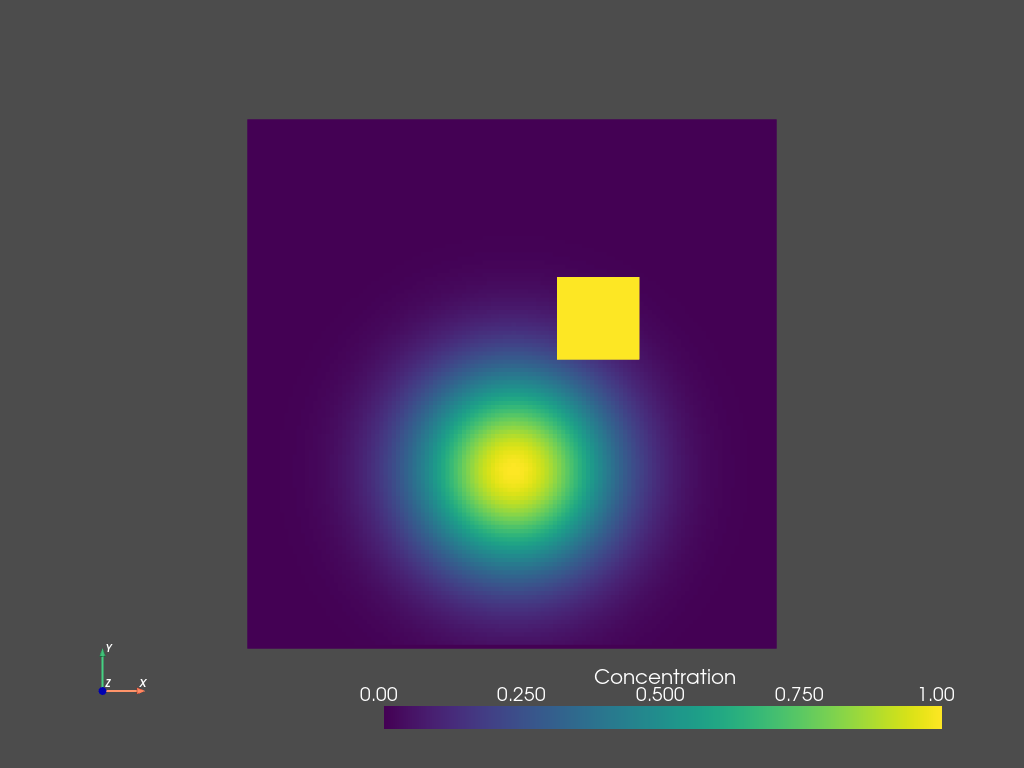

In [18]:
mesh.point_data = {'Concentration': values_}
mesh.plot(notebook=True, cpos='xy', clim=[0,1], style='points', jupyter_backend='static')

# Graph Neural Network

In [19]:
def set_boundary_conds(values): 
    '''Function to set the boundary nodes of the tensor 'values' to 0'''
    
    x_min = mesh.points.transpose()[0].min()
    x_max = mesh.points.transpose()[0].max()
    y_min = mesh.points.transpose()[1].min()
    y_max = mesh.points.transpose()[1].max()
    for i in range(nonods):
        if mesh.points.transpose()[0][i] == x_min or mesh.points.transpose()[0][i] == x_max or mesh.points.transpose()[1][i] == y_min or mesh.points.transpose()[1][i] == y_max:
            values[i][0] = 0

In [20]:
class GNN(nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
    
    def forward(self, values, ml=ml_sparse, ml_inv=ml_inv_sparse, a=a_sparse, dt=dt):
        '''Graph Neural Network to solve the scalar transport equation
        
        Inputs
        ---------------------------------------------------------------------------------
        values: Initial scalar field of the system in shape(nonods,1) as a torch tensor
        ml: Mass lumped matrix of the FEM discretization in shape(nonods, nonods) as a torch COO sparse tensor 
        ml_inv: Inverse of the mass lumped matrix in shape(nonods,nonods) as a torch COO sparse tensor
        a: FEM matrix that solves the equation: Ax=b, in shape(nonods,nonods) as a torch COO sparse tensor
        dt: Timestep in s
        
        '''
        
        # Get weights and time step
        values = torch.sparse.mm(torch.sparse.mm(- ml_inv, - ml + (dt * a)), values.view(nonods, 1))
        
        # set boundary conds.
        set_boundary_conds(values)
        
        return values   

# Timestepping

In [21]:
# Initalize values_py
values_py = values_

In [30]:
# timestep
start = time.time() 
with torch.no_grad():
    for i in range(100):
        model = GNN()
        values_py = model(values=values_py)
        
end = time.time()
print('Computational time(s):',(end-start))

# 100 timesteps

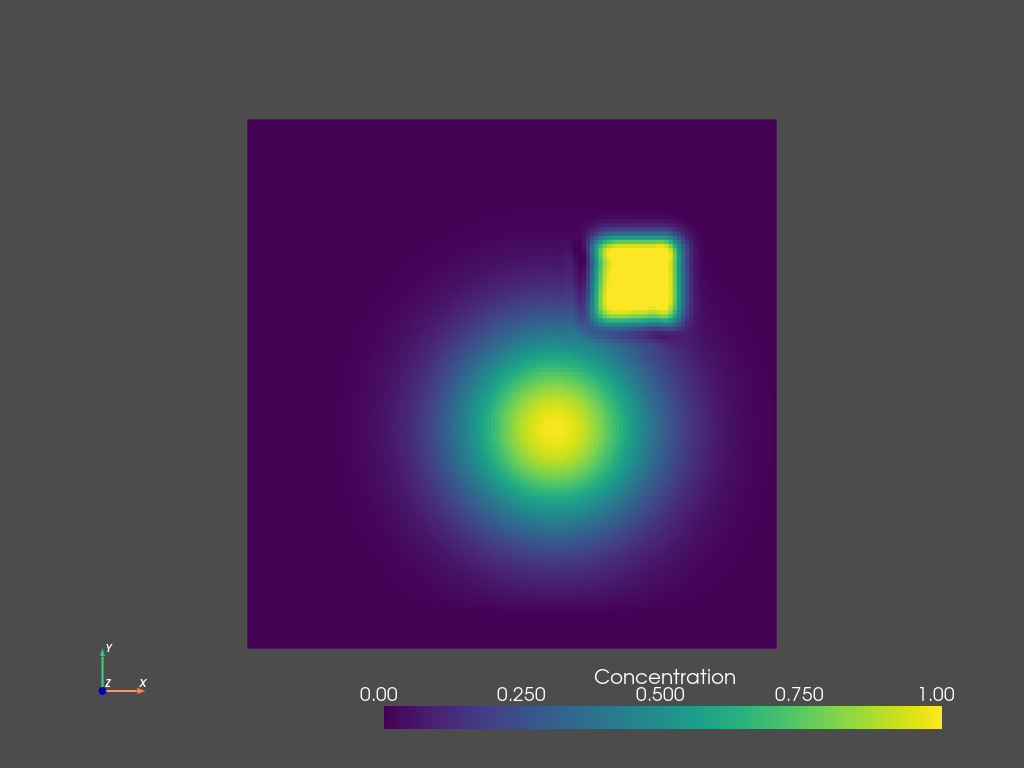

In [23]:
mesh.point_data = {'Concentration': values_py}
mesh.plot(notebook=True, cpos='xy', clim=[0,1], style='points', jupyter_backend='static')

# 200 timesteps

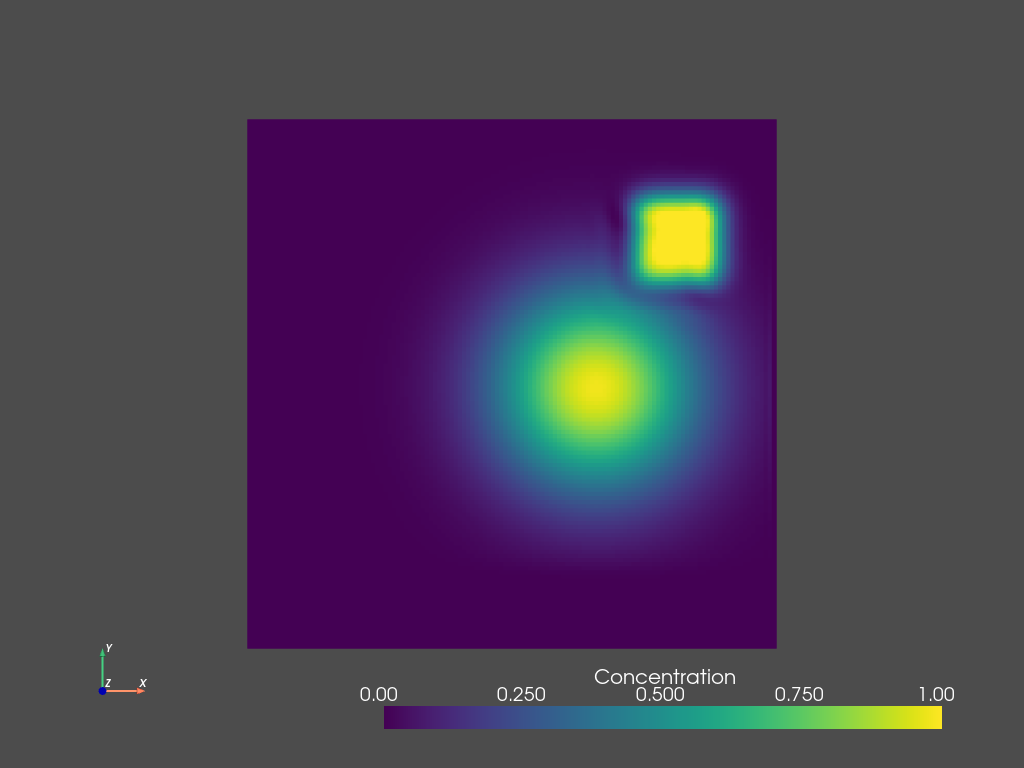

In [25]:
mesh.point_data = {'Concentration': values_py}
mesh.plot(notebook=True, cpos='xy', clim=[0,1], style='points', jupyter_backend='static')

# 300 timesteps

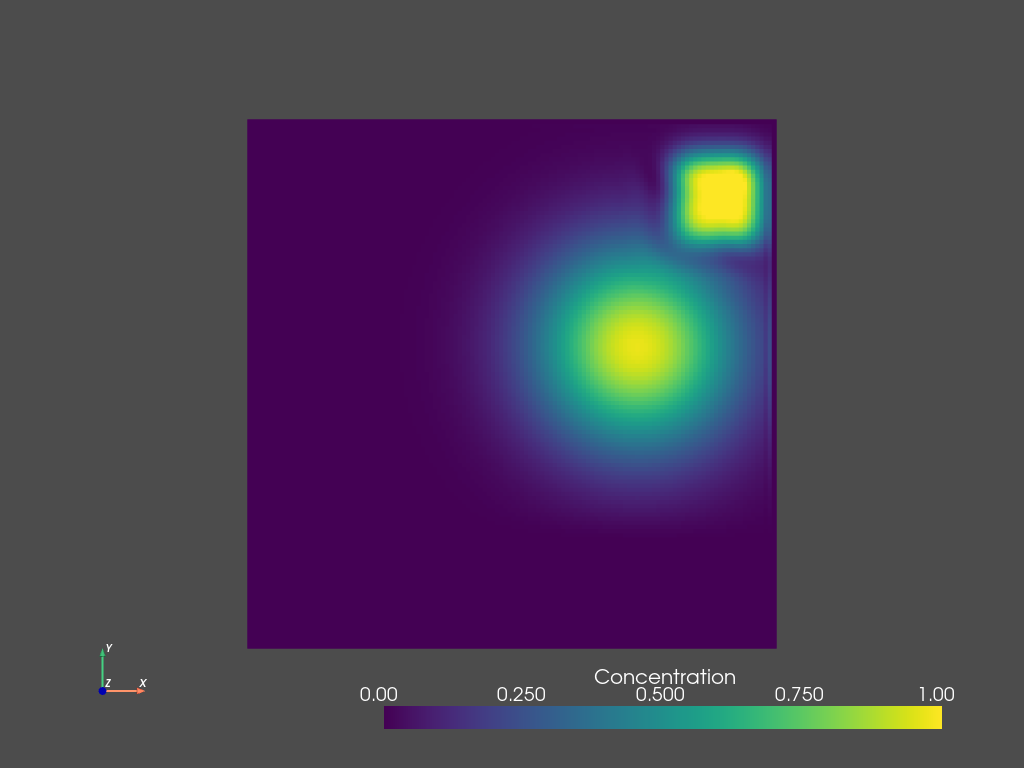

In [27]:
mesh.point_data = {'Concentration': values_py}
mesh.plot(notebook=True, cpos='xy', clim=[0,1], style='points', jupyter_backend='static')

# 400 timesteps

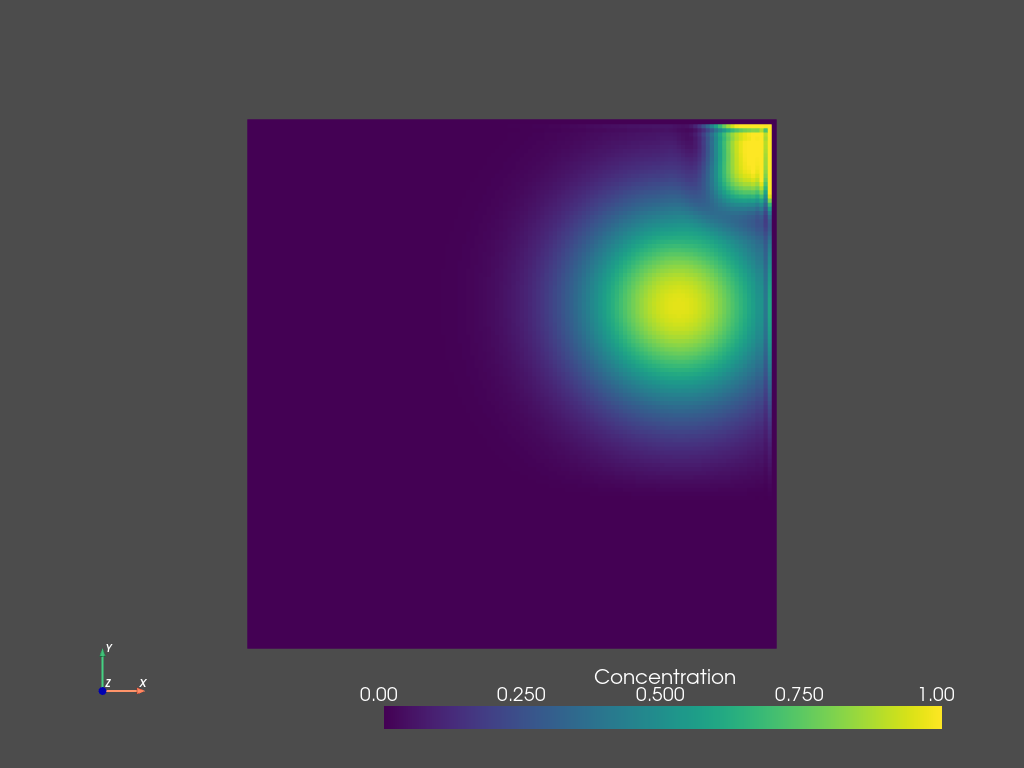

In [29]:
mesh.point_data = {'Concentration': values_py}
mesh.plot(notebook=True, cpos='xy', clim=[0,1], style='points', jupyter_backend='static')

# 500 timesteps

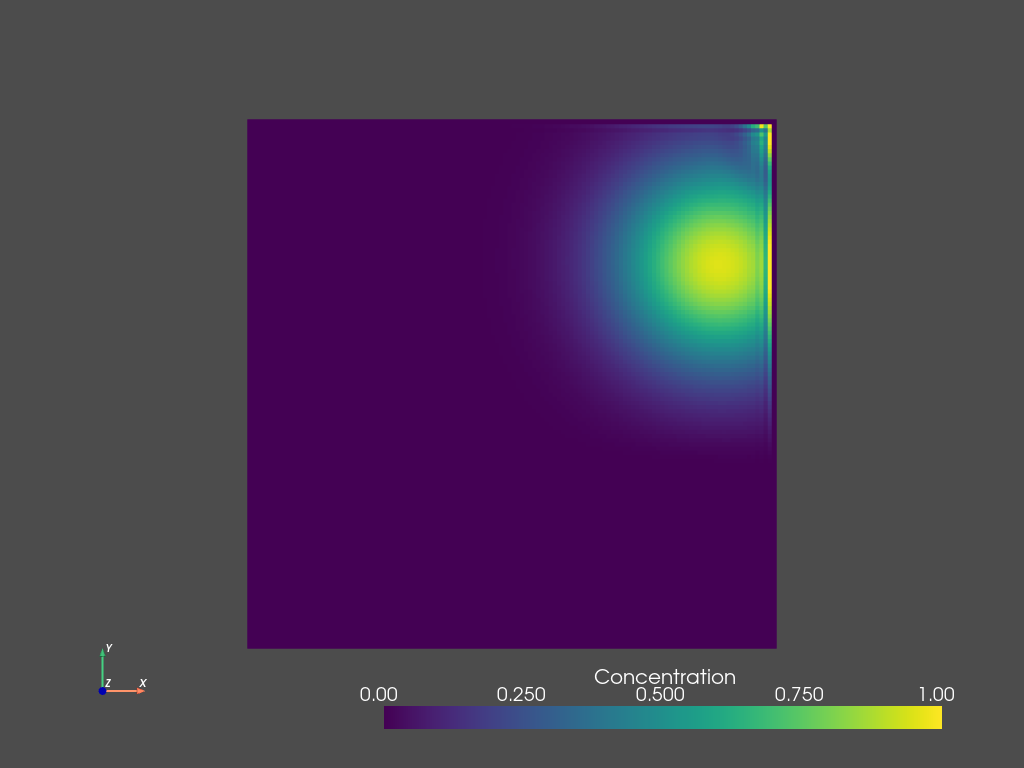

In [31]:
mesh.point_data = {'Concentration': values_py}
mesh.plot(notebook=True, cpos='xy', clim=[0,1], style='points', jupyter_backend='static')